# Import Packages

In [1]:
import os, joblib, json
import sys
import re
import html
import json
import time
import warnings
from collections import deque

import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import (
    normalize, StandardScaler, LabelEncoder, MaxAbsScaler, Normalizer
)
from scipy.sparse import issparse

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import umap

from sklearn.metrics import (
    silhouette_score, adjusted_rand_score, normalized_mutual_info_score,
    confusion_matrix, accuracy_score, make_scorer, pairwise_distances
)
from scipy.optimize import linear_sum_assignment

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from skopt import BayesSearchCV
from skopt.space import Categorical
from skopt.callbacks import DeltaYStopper, DeadlineStopper
from skopt.utils import point_asdict

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

/Users/brytaniavalerie/Desktop/IT1244/venv-it1244/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data

In [2]:
df_cleaned = pd.read_csv("cleaned_tweets.csv")
texts = df_cleaned["clean_text"].astype(str).tolist()

df_cleaned_sample = pd.read_csv("cleaned_sample_tweets.csv")

# TF-IDF

In [3]:
# ---------------------------
# CONFIG
# ---------------------------
RANDOM_STATE = 42
TOTAL_ITERS  = 60         
N_CLUSTERS   = 3 

In [4]:
# Encode labels (fit on FULL so sample + full share the same mapping)
le = LabelEncoder()
le.fit(df_cleaned["airline_sentiment"].astype(str))
y_full_enc   = le.transform(df_cleaned["airline_sentiment"].astype(str))
y_sample_enc = le.transform(df_cleaned_sample["airline_sentiment"].astype(str))

# ---------------------------
# TF-IDF (SAMPLE) + zero-row mask  ← BayesSearch uses THIS
# ---------------------------
tfidf_sample = TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_df=0.9, max_features=5000, norm='l2')
X_sample = tfidf_sample.fit_transform(df_cleaned_sample['clean_text'].astype(str))
# mask out rows that are empty after TF-IDF (zero vectors)
nz_mask_s   = X_sample.getnnz(axis=1) > 0
X_sample_nz = X_sample[nz_mask_s]
y_sample_enc_nz = y_sample_enc[nz_mask_s]

print(f"[SAMPLE] TF-IDF: {X_sample.shape} -> non-zero: {X_sample_nz.shape}")

# ---------------------------
# TF-IDF (FULL) + zero-row mask  ← Final refit/eval uses THIS
# ---------------------------
tfidf_full = TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_df=0.9, max_features=5000, norm='l2')
X_full = tfidf_full.fit_transform(df_cleaned['clean_text'].astype(str))
# mask out rows that are empty after TF-IDF (zero vectors)
nz_mask_f   = X_full.getnnz(axis=1) > 0
X_full_nz   = X_full[nz_mask_f]
y_full_enc_nz = y_full_enc[nz_mask_f]

print(f"[FULL] TF-IDF: {X_full.shape} -> non-zero: {X_full_nz.shape}")

# ---------------------------
# Prepare Data
# ---------------------------
texts_sample = df_cleaned_sample["clean_text"].astype(str).tolist()
texts_full   = df_cleaned["clean_text"].astype(str).tolist()

le = LabelEncoder()
le.fit(df_cleaned["airline_sentiment"].astype(str))
y_sample_enc = le.transform(df_cleaned_sample["airline_sentiment"].astype(str))
y_full_enc   = le.transform(df_cleaned["airline_sentiment"].astype(str))

# ----------------------------------------------------------
# Compute or load cached TF-IDF embeddings
# ----------------------------------------------------------
from scipy.sparse import issparse, save_npz, load_npz

os.makedirs("model", exist_ok=True)

# make sure tfidf_full is FITTED already:
if not hasattr(tfidf_full, "vocabulary_"):
    tfidf_full.fit(df_cleaned['clean_text'].astype(str))

def get_or_build_embeddings(path, builder_fn):
    if os.path.exists(path):
        print(f"🔁 Loading cached embeddings from {path}")
        # load sparse if .npz, else dense .npy
        return load_npz(path) if path.endswith(".npz") else np.load(path, mmap_mode="r")

    print(f"⚙️ Computing embeddings → {path}")
    X = builder_fn()  # must RETURN the matrix/array (sparse or dense)

    # save sparse vs dense appropriately
    if issparse(X):
        save_npz(path, X)
    else:
        try:
            import torch  # noqa
            if hasattr(X, "detach"):
                X = X.detach().cpu().numpy()
        except Exception:
            pass
        X = np.asarray(X, dtype=np.float32)
        np.save(path, X)
    return X

# Use lambdas that CALL the vectorizer; cache as .npz because TF-IDF is sparse
X_tfidf_full   = get_or_build_embeddings("model/X_tfidf_full.npz", lambda: tfidf_full.transform(texts_full))
X_tfidf_sample = get_or_build_embeddings("model/X_tfidf_sample.npz",lambda: tfidf_full.transform(texts_sample))

[SAMPLE] TF-IDF: (2928, 1118) -> non-zero: (2896, 1118)
[FULL] TF-IDF: (14639, 4756) -> non-zero: (14588, 4756)
🔁 Loading cached embeddings from model/X_tfidf_full.npz
🔁 Loading cached embeddings from model/X_tfidf_sample.npz


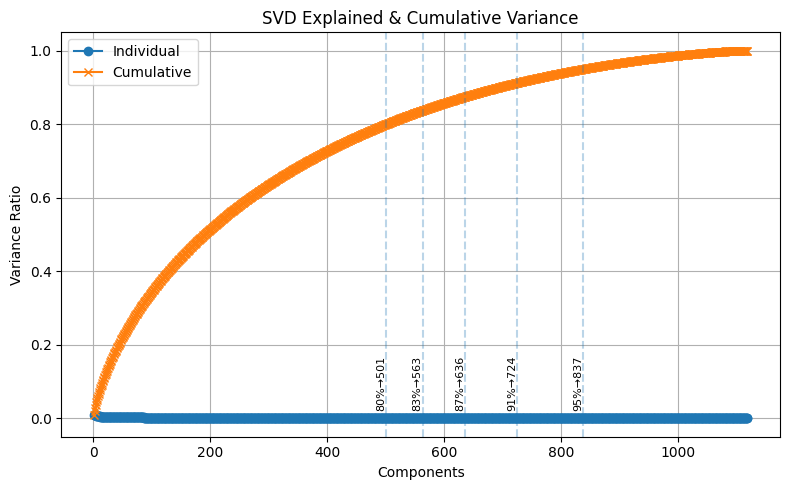

SVD n_components candidates (80–95% cum var): [501, 563, 636, 724, 837]


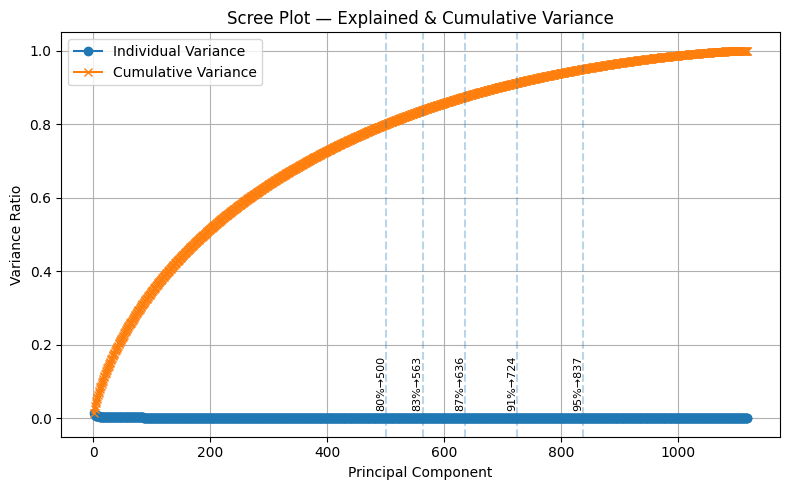

PCA n_components candidates (80–95% cumulative variance): [500, 563, 636, 724, 837]


In [5]:
# ---------------------------
# Metrics
# ---------------------------
def hungarian_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    r, c = linear_sum_assignment(-cm)
    return cm[r, c].sum() / cm.sum()

def evaluate_full(X, y_true_int, labels, sil_metric):
    sil = silhouette_score(X, labels, metric=sil_metric)
    ari = adjusted_rand_score(y_true_int, labels)
    nmi = normalized_mutual_info_score(y_true_int, labels)
    acc = hungarian_accuracy(y_true_int, labels)
    return sil, ari, nmi, acc

# ---------------------------
# SVD Scree Plot + pick 5 n_components (80–95% cum var, evenly spaced)
# ---------------------------

def pick_svd_candidates(X, pct_low=0.80, pct_high=0.95, k=5, max_components=None, plot=True):
    """
    Select a list of n_components based on cumulative explained variance for SVD.
    The function will pick k candidates based on variance thresholds between pct_low and pct_high.
    
    Parameters:
    - X: Input data matrix (sparse matrix is allowed)
    - pct_low: Minimum cumulative variance threshold (default 0.80)
    - pct_high: Maximum cumulative variance threshold (default 0.95)
    - k: Number of n_components to select (default 5)
    - max_components: Maximum number of components to consider (default None)
    - plot: Whether to plot the cumulative variance explained (default True)
    
    Returns:
    - comps_unique: List of selected n_components based on variance thresholds
    - cum: Cumulative explained variance for each component
    """
    if max_components is None:
        max_components = X.shape[1]
    
    # Scale data (Standardize)
    X_std = MaxAbsScaler().fit_transform(X)
    
    # Fit SVD
    svd = TruncatedSVD(n_components=max_components, random_state=42)
    svd.fit(X_std)
    
    # Explained variance and cumulative variance
    evr = svd.explained_variance_ratio_
    cum = np.cumsum(evr)

    # Determine thresholds and find components
    thresholds = np.linspace(pct_low, pct_high, k)
    comps = []
    for t in thresholds:
        idx = int(np.argmax(cum >= t)) + 1
        comps.append(idx)

    # Deduplicate and preserve order
    seen = set()
    comps_unique = []
    for c in comps:
        if c not in seen:
            comps_unique.append(c)
            seen.add(c)

    # Ensure exactly k values (best-effort padding)
    while len(comps_unique) < k:
        step = max(1, (comps_unique[-1] - comps_unique[0]) // (k - 1))
        candidate = min(max_components, comps_unique[-1] + step)
        if candidate not in seen:
            comps_unique.append(candidate)
            seen.add(candidate)
        else:
            candidate = min(max_components, candidate + 1)
            if candidate not in seen:
                comps_unique.append(candidate)
                seen.add(candidate)
            else:
                break

    comps_unique = sorted(comps_unique)[:k]

    # Plot 
    if plot:
        xs = np.arange(1, len(evr) + 1)
        plt.figure(figsize=(8, 5))
        plt.plot(xs, evr, marker='o', label='Individual')
        plt.plot(xs, cum, marker='x', label='Cumulative')
        for t, c in zip(thresholds, comps):
            plt.axvline(c, linestyle='--', alpha=0.3)
            plt.text(c, 0.02, f'{int(t * 100)}%→{c}', rotation=90, va='bottom', ha='right', fontsize=8)
        plt.title('SVD Explained & Cumulative Variance')
        plt.xlabel('Components')
        plt.ylabel('Variance Ratio')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return comps_unique, cum

# Example usage with TF-IDF matrix (tfidf_matrix):
svd_candidates, _cum = pick_svd_candidates(X_sample, pct_low=0.80, pct_high=0.95, k=5, plot=True)
print("SVD n_components candidates (80–95% cum var):", svd_candidates)

# ---------------------------
# PCA Scree Plot + pick 5 n_components (80–95% cum var, evenly spaced)
# ---------------------------
def pick_pca_candidates(X, pct_low=0.80, pct_high=0.95, k=5, max_components=None, plot=True):
    # Convert sparse matrix to dense array and standardize
    X_dense = X.toarray() if hasattr(X, 'toarray') else X  # If it's sparse, convert it to dense
    Xs = MaxAbsScaler().fit_transform(X_dense)

    # If max_components is not provided, set it to the number of features (columns)
    if max_components is None:
        max_components = Xs.shape[1]

    # PCA fitting
    pca = PCA(n_components=max_components, random_state=42)
    pca.fit(Xs)
    
    # Explained variance ratio and cumulative variance
    evr = pca.explained_variance_ratio_
    cum = np.cumsum(evr)

    # Find n_components for the given variance thresholds (80%-95%)
    thresholds = np.linspace(pct_low, pct_high, k)
    comps = []
    for t in thresholds:
        idx = int(np.argmax(cum >= t)) + 1
        comps.append(idx)

    # Deduplicate and maintain order
    seen = set()
    comps_unique = []
    for c in comps:
        if c not in seen:
            comps_unique.append(c)
            seen.add(c)
    
    # Ensure exactly k values by padding 
    while len(comps_unique) < k:
        step = max(1, (comps_unique[-1] - comps_unique[0]) // (k-1))
        candidate = min(max_components, comps_unique[-1] + step)
        if candidate not in seen:
            comps_unique.append(candidate)
            seen.add(candidate)
        else:
            candidate = min(max_components, candidate + 1)
            if candidate not in seen:
                comps_unique.append(candidate)
                seen.add(candidate)
            else:
                break

    comps_unique = sorted(comps_unique)[:k]

    # Plotting the explained and cumulative variance
    if plot:
        xs = np.arange(1, len(evr) + 1)
        plt.figure(figsize=(8, 5))
        plt.plot(xs, evr, marker='o', label='Individual Variance')
        plt.plot(xs, cum, marker='x', label='Cumulative Variance')
        for t, c in zip(thresholds, comps):
            plt.axvline(c, linestyle='--', alpha=0.3)
            plt.text(c, 0.02, f'{int(t * 100)}%→{c}', rotation=90, va='bottom', ha='right', fontsize=8)
        plt.title('Scree Plot — Explained & Cumulative Variance')
        plt.xlabel('Principal Component')
        plt.ylabel('Variance Ratio')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return comps_unique, cum

# Assuming X_sample is TF-IDF matrix
pca_candidates, _cum = pick_pca_candidates(
    X_sample, pct_low=0.80, pct_high=0.95, k=5, plot=True
)
print("PCA n_components candidates (80–95% cumulative variance):", pca_candidates)

# Fixed UMAP candidate grids
umap_neighbors  = [15, 30, 45, 60, 75, 100, 150, 200]
umap_min_dist   = [0.1, 0.2, 0.3, 0.4, 0.5]
umap_components = [16, 32, 48, 64, 96, 128]

# ---------------------------
# ClusteringPipeline class (for BayesSearchCV)
# ---------------------------
_LAST_TRIAL = deque(maxlen=1)

class ClusteringPipeline(BaseEstimator):
    def __init__(self,
                 reducer='pca', n_components=50,
                 n_neighbors=15, min_dist=0.1, n_components_umap=16,
                 model='kmeans', cov_type='full', linkage='average'):
        self.reducer = reducer
        self.n_components = n_components
        self.n_neighbors = n_neighbors
        self.min_dist = min_dist
        self.n_components_umap = n_components_umap
        self.model = model
        self.cov_type = cov_type
        self.linkage = linkage

    def fit(self, X, y=None):
        _LAST_TRIAL.clear()
        _LAST_TRIAL.append({
            'reducer'          : self.reducer,
            'n_components'     : self.n_components,
            'n_neighbors'      : self.n_neighbors,
            'min_dist'         : self.min_dist,
            'n_components_umap': self.n_components_umap,
            'model'            : self.model,
            'cov_type'         : self.cov_type,
            'linkage'          : self.linkage,
        })

        # Remove zero vectors
        nonzero_rows = np.where(np.sum(X, axis=1) > 0)[0]
        X_nonzero = X[nonzero_rows]

        # ---------------- Reducer ----------------
        if self.reducer == 'svd':
            X_std = MaxAbsScaler().fit_transform(X_nonzero)
            X_red = TruncatedSVD(n_components=self.n_components, random_state=RANDOM_STATE).fit_transform(X_std)
        elif self.reducer == 'pca':
            X_std = MaxAbsScaler().fit_transform(X_nonzero)
            X_red = PCA(n_components=self.n_components, random_state=RANDOM_STATE).fit_transform(X_std)
        else:
            X_l2 = normalize(X_nonzero)
            X_red = umap.UMAP(
                n_neighbors=self.n_neighbors,
                min_dist=self.min_dist,
                n_components=self.n_components_umap,
                metric='cosine',
                random_state=RANDOM_STATE,
                n_epochs=120,
                low_memory=True
            ).fit_transform(X_l2)

        # ---------------- Clustering ----------------
        if self.model == 'kmeans':
            X_use = normalize(X_red)
            labels = KMeans(n_clusters=3, n_init=10, algorithm='elkan', random_state=RANDOM_STATE).fit_predict(X_use)
            self.metric = "cosine"
        elif self.model == 'gmm':
            X_use = np.asarray(X_red, dtype=np.float64)
            try:
                labels = GaussianMixture(
                    n_components=3, n_init=10, random_state=RANDOM_STATE,
                    covariance_type=self.cov_type
                ).fit_predict(X_use)
            except ValueError:
                labels = GaussianMixture(
                    n_components=3, n_init=10, random_state=RANDOM_STATE,
                    covariance_type=self.cov_type, reg_covar=1e-5
                ).fit_predict(X_use)
            self.metric = "euclidean"
        else:  # Agglo
            X_use = normalize(X_red)
            labels = AgglomerativeClustering(
                n_clusters=3, linkage=self.linkage, metric='cosine'
            ).fit_predict(X_use)
            self.metric = "cosine"

        # store for score()
        self.labels_ = labels
        self.X_use_  = X_use
        self.score_  = silhouette_score(X_use, labels, metric=self.metric)
        return self

    def score(self, X, y=None):
        return self.score_

In [6]:
# ---------------------------
# Bayesian Search Space 
# ---------------------------
search_spaces = [
    # SVD + KMeans
    {
        'reducer'      : Categorical(['svd'],        name='reducer'),
        'n_components' : Categorical(svd_candidates, name='n_components'),
        'model'        : Categorical(['kmeans'],     name='model'),
    },
    # SVD + GMM
    {
        'reducer'      : Categorical(['svd'],        name='reducer'),
        'n_components' : Categorical(svd_candidates, name='n_components'),
        'model'        : Categorical(['gmm'],        name='model'),
        'cov_type'     : Categorical(['full','tied','diag','spherical'], name='cov_type'),
    },
    # SVD + Agglo
    {
        'reducer'      : Categorical(['svd'],        name='reducer'),
        'n_components' : Categorical(svd_candidates, name='n_components'),
        'model'        : Categorical(['agglo'],      name='model'),
        'linkage'      : Categorical(['average','complete','single'], name='linkage'),
    },
    # PCA + KMeans
    {
        'reducer'      : Categorical(['pca'],        name='reducer'),
        'n_components' : Categorical(pca_candidates, name='n_components'),
        'model'        : Categorical(['kmeans'],     name='model'),
    },
    # PCA + GMM
    {
        'reducer'      : Categorical(['pca'],        name='reducer'),
        'n_components' : Categorical(pca_candidates, name='n_components'),
        'model'        : Categorical(['gmm'],        name='model'),
        'cov_type'     : Categorical(['full','tied','diag','spherical'], name='cov_type'),
    },
    # PCA + Agglo (no 'ward' since metric='cosine')
    {
        'reducer'      : Categorical(['pca'],        name='reducer'),
        'n_components' : Categorical(pca_candidates, name='n_components'),
        'model'        : Categorical(['agglo'],      name='model'),
        'linkage'      : Categorical(['average','complete','single'], name='linkage'),
    },

    # UMAP + KMeans
    {
        'reducer'           : Categorical(['umap'],  name='reducer'),
        'n_neighbors'       : Categorical(umap_neighbors,  name='n_neighbors'),
        'min_dist'          : Categorical(umap_min_dist,   name='min_dist'),
        'n_components_umap' : Categorical(umap_components, name='n_components_umap'),
        'model'             : Categorical(['kmeans'],      name='model'),
    },
    # UMAP + GMM
    {
        'reducer'           : Categorical(['umap'],  name='reducer'),
        'n_neighbors'       : Categorical(umap_neighbors,  name='n_neighbors'),
        'min_dist'          : Categorical(umap_min_dist,   name='min_dist'),
        'n_components_umap' : Categorical(umap_components, name='n_components_umap'),
        'model'             : Categorical(['gmm'],         name='model'),
        'cov_type'          : Categorical(['full','tied','diag','spherical'], name='cov_type'),
    },
    # UMAP + Agglo
    {
        'reducer'           : Categorical(['umap'],  name='reducer'),
        'n_neighbors'       : Categorical(umap_neighbors,  name='n_neighbors'),
        'min_dist'          : Categorical(umap_min_dist,   name='min_dist'),
        'n_components_umap' : Categorical(umap_components, name='n_components_umap'),
        'model'             : Categorical(['agglo'],       name='model'),
        'linkage'           : Categorical(['average','complete','single'], name='linkage'),
    },
]

# --- progress/timing callback for BayesSearchCV (with robust fallback) ---
TOTAL_ITERS = 60  # keep in sync with BayesSearchCV(n_iter=...)

_timings = []
_start = [None]
_prev  = [None]

def _short_params(d):
    keys = [
        'reducer','n_components','n_neighbors','min_dist','n_components_umap',
        'model','cov_type','linkage'
    ]
    return {k: d[k] for k in keys if k in d}

def _infer_branch_from_space(space):
    """Infer branch name (reducer+model) from single-choice categories in subspace."""
    reducer = model = None
    for dim in getattr(space, "dimensions", []):
        cats = getattr(dim, "categories", None)
        if not cats or not hasattr(cats, "__iter__"):
            continue
        if len(cats) == 1:
            v = cats[0]
            if v in ("svd", "pca", "umap"):
                reducer = v
            elif v in ("kmeans", "gmm", "agglo"):
                model = v
    return f"{reducer or '?'}+{model or '?'}"

def progress_callback(res):
    import time, numpy as np
    now = time.perf_counter()
    if _start[0] is None:
        _start[0] = now
    if _prev[0] is not None:
        _timings.append(now - _prev[0])

    k = len(res.x_iters)
    avg = float(np.mean(_timings)) if _timings else 0.0
    elapsed = now - _start[0]
    remaining = max(TOTAL_ITERS - k, 0) * (avg if avg > 0 else 0.0)

    # Try to get the reducer/model from the latest evaluated point
    branch = None
    try:
        if res.x_iters:
            last_params = point_asdict(res.space, res.x_iters[-1])
            r, m = last_params.get("reducer"), last_params.get("model")
            if r and m:
                branch = f"{r}+{m}"
    except Exception:
        pass

    # Fallback: infer directly from this subspace definition
    if branch is None:
        branch = _infer_branch_from_space(res.space)

    last_dt = _timings[-1] if _timings else 0.0
    print(
        f"[Bayes] iter {k:>3}/{TOTAL_ITERS} ({k/TOTAL_ITERS:5.1%}) "
        f"| last {last_dt:5.2f}s avg {avg:5.2f}s "
        f"| elapsed {elapsed/60:4.1f}m ETA ~{remaining/60:4.1f}m "
        f"| branch {branch} (Using TF-IDF)",  # Added "(Using TF-IDF)" for clarity
        flush=True
    )
    _prev[0] = now
    return False

# ---------------------------
# Run Bayesian SearchCV for TF-IDF
# ---------------------------
n = X_tfidf_sample.shape[0]                    # CHANGED: use the same matrix you pass to .fit()
dummy_y = np.zeros(n, dtype=int)
cv_full = [(np.arange(n), np.arange(n))]

search = BayesSearchCV(
    estimator=ClusteringPipeline(),
    search_spaces=search_spaces,
    n_iter=TOTAL_ITERS,
    random_state=RANDOM_STATE,
    scoring=None,                  # estimator.score_ (silhouette)
    cv=cv_full,
    n_points=4,
    n_jobs=-1,
    return_train_score=False
)

print("\n=== Running BayesSearchCV (SVD/PCA/UMAP × KMeans/GMM/Agglo) ===")

callbacks = [
    DeltaYStopper(delta=1e-4, n_best=15),
    progress_callback
]

_prev[0] = time.perf_counter()
_start[0] = _prev[0]


# === Refit best params on FULL data and save ===
os.makedirs("model", exist_ok=True)
SUBSET_PIPE = "model/tfidf_pipeline.pkl"
META_JSON   = "model/tfidf_pipeline_meta.json"


if os.path.exists(SUBSET_PIPE) and os.path.exists(META_JSON):
    print("Cached best pipeline & meta already exist.")
else:
    print("Running BayesSearchCV (first time or meta missing)...")
    search.fit(X_tfidf_sample, dummy_y, callback=callbacks)
    best_estimator = search.best_estimator_

    # ============================================================
    # Build per-branch best (subset), then pick FULL-data winner.
    # ============================================================
    cv = pd.DataFrame(search.cv_results_)
    param_cols = [c for c in cv.columns if c.startswith("param_")]
    score_col  = "mean_test_score"

    # ---- 1) Per-branch best on subset (by silhouette) ----
    cv["branch"] = cv.apply(lambda r: f"{r.get('param_reducer')}+{r.get('param_model')}", axis=1)
    best_idx = cv.groupby("branch")[score_col].idxmax()
    best_rows = cv.loc[best_idx].reset_index(drop=True)

    branch_best = {}
    for _, r in best_rows.iterrows():
        params = {p.replace("param_",""): r[p] for p in param_cols if pd.notnull(r[p])}
        for k in ("n_components","n_neighbors","n_components_umap"):
            if k in params and params[k] is not None:
                params[k] = int(params[k])
        if "min_dist" in params and params["min_dist"] is not None:
            params["min_dist"] = float(params["min_dist"])
        key = f"{params.get('reducer')}+{params.get('model')}"
        branch_best[key] = {"silhouette_subset": float(r[score_col]), **params}

    # ---- 2) Evaluate each branch winner on FULL; pick Hungarian winner ----
    assert "X_tfidf_full" in globals()
    assert "y_full_enc" in globals()

    # CHANGED: compute the non-zero mask from the SAME matrix used to fit
    nz_full = np.asarray(X_tfidf_full.getnnz(axis=1) > 0).ravel()

    full_eval_rows = []
    best_hungarian = -1.0
    best_record    = None
    best_fitted    = None

    for bkey, rec in branch_best.items():
        params = {k: rec.get(k) for k in
                  ["reducer","model","n_components","n_neighbors","min_dist",
                   "n_components_umap","cov_type","linkage"] if rec.get(k) is not None}

        mdl = ClusteringPipeline(**params).fit(X_tfidf_full)
        labels = mdl.labels_
        metric = getattr(mdl, "metric", "cosine")

        # CHANGED: slice labels to non-zero rows so lengths match
        sil, ari, nmi, acc = evaluate_full(mdl.X_use_, y_full_enc[nz_full], labels, metric)

        row = {
            "branch": bkey,
            "params": params,
            "Silhouette": float(sil),
            "ARI": float(ari),
            "NMI": float(nmi),
            "Hungarian": float(acc),
            "metric_used": metric
        }
        full_eval_rows.append(row)

        if acc > best_hungarian:
            best_hungarian = acc
            best_record    = row
            best_fitted    = mdl

    # ---- 3) Persist meta ----
    META_JSON = "model/tfidf_pipeline_meta.json"
    meta_payload = {
        "branch_bests": branch_best,
        "full_eval": full_eval_rows,
        "winner_metric": "Hungarian",
        "winner": {
            "branch": best_record["branch"],
            "params": best_record["params"],
            "Silhouette": best_record["Silhouette"],
            "ARI": best_record["ARI"],
            "NMI": best_record["NMI"],
            "Hungarian": best_record["Hungarian"],
            "metric_used_for_silhouette": best_record["metric_used"]
        }
    }
    with open(META_JSON, "w") as f:
        json.dump(meta_payload, f, indent=2)
    print(f"Saved meta (per-branch + full eval + winner) → {META_JSON}")

    # ---- 4) Save the best FULL model ----
    SUBSET_PIPE = "model/tfidf_pipeline.pkl"
    joblib.dump(best_fitted, SUBSET_PIPE)
    print(f"Saved BEST (by Hungarian on FULL) pipeline → {SUBSET_PIPE}")


=== Running BayesSearchCV (SVD/PCA/UMAP × KMeans/GMM/Agglo) ===
Running BayesSearchCV (first time or meta missing)...
[Bayes] iter   4/60 ( 6.7%) | last 17.60s avg 17.60s | elapsed  0.3m ETA ~16.4m | branch svd+kmeans (Using TF-IDF)
[Bayes] iter   8/60 (13.3%) | last 14.43s avg 16.01s | elapsed  0.5m ETA ~13.9m | branch svd+kmeans (Using TF-IDF)
[Bayes] iter  12/60 (20.0%) | last 12.54s avg 14.86s | elapsed  0.7m ETA ~11.9m | branch svd+kmeans (Using TF-IDF)
[Bayes] iter  16/60 (26.7%) | last 14.09s avg 14.66s | elapsed  1.0m ETA ~10.8m | branch svd+kmeans (Using TF-IDF)
[Bayes] iter  20/60 (33.3%) | last  4.95s avg 12.72s | elapsed  1.1m ETA ~ 8.5m | branch svd+kmeans (Using TF-IDF)
[Bayes] iter  24/60 (40.0%) | last  5.14s avg 11.46s | elapsed  1.1m ETA ~ 6.9m | branch svd+kmeans (Using TF-IDF)
[Bayes] iter  28/60 (46.7%) | last  5.80s avg 10.65s | elapsed  1.2m ETA ~ 5.7m | branch svd+kmeans (Using TF-IDF)
[Bayes] iter  32/60 (53.3%) | last  5.10s avg  9.96s | elapsed  1.3m ETA ~ 4

In [7]:
META_JSON = "model/tfidf_pipeline_meta.json"
assert os.path.exists(META_JSON), "Missing model/tfidf_pipeline_meta.json — run the tuning step first."


with open(META_JSON, "r") as f:
   meta = json.load(f)


# ---------------------------
# Build: Best per branch (TFIDF, 20% subset) table
# ---------------------------
branch_bests = meta["branch_bests"]  # dict: key="reducer+model" → params + silhouette_subset


rows = []
for branch, rec in sorted(branch_bests.items()):
   rows.append({
       "branch": branch,
       "best_sil_subset": round(float(rec.get("silhouette_subset", np.nan)), 4),
       "reducer": rec.get("reducer"),
       "model": rec.get("model"),
       "n_components": rec.get("n_components"),
       "n_neighbors": rec.get("n_neighbors"),
       "min_dist": rec.get("min_dist"),
       "n_components_umap": rec.get("n_components_umap"),
       "cov_type": rec.get("cov_type"),
       "linkage": rec.get("linkage"),
   })


df_best_subset = pd.DataFrame(rows).sort_values("branch")


print("\n================ Best Parameters per Branch (TFIDF, 20% subset) ================\n")
print(df_best_subset[[
   "branch","best_sil_subset","reducer","model","n_components",
   "n_neighbors","min_dist","n_components_umap","cov_type","linkage"
]].to_string(index=False))


# ---------------------------
# Build: Final Evaluation on Full table
# ---------------------------
def _params_compact(d):
   # compact, branch-aware param string
   out = [f"reducer={d['reducer']}", f"model={d['model']}"]
   if d["reducer"] == "pca":
       if d.get("n_components") is not None: out.append(f"n_components={d['n_components']}")
   elif d["reducer"] == "umap":
       for k in ("n_neighbors","min_dist","n_components_umap"):
           if d.get(k) is not None: out.append(f"{k}={d[k]}")
   if d["model"] == "gmm" and d.get("cov_type") is not None:
       out.append(f"cov_type={d['cov_type']}")
   if d["model"] == "agglo" and d.get("linkage") is not None:
       out.append(f"linkage={d['linkage']}")
   return ", ".join(out)


full_eval_rows = meta["full_eval"]  # list of dicts for each branch (Silhouette, ARI, NMI, Hungarian, params, etc.)


final_rows = []
for rec in sorted(full_eval_rows, key=lambda x: x["branch"]):
   params = rec["params"]
   row = {
       "branch": rec["branch"],
       "Silhouette": round(float(rec["Silhouette"]), 3) if rec["Silhouette"] is not None else np.nan,
       "ARI": round(float(rec["ARI"]), 3) if rec["ARI"] is not None else np.nan,
       "NMI": round(float(rec["NMI"]), 3) if rec["NMI"] is not None else np.nan,
       "Hungarian": round(float(rec["Hungarian"]), 3) if rec["Hungarian"] is not None else np.nan,
       "Params": _params_compact(params)
   }
   final_rows.append(row)


df_final = pd.DataFrame(final_rows).sort_values("branch")


print("\n================ Final Evaluation on Full Minimal-Cleaned Data (TFIDF — Best of Each Branch) ================\n")
print(df_final[["branch","Silhouette","ARI","NMI","Hungarian","Params"]].to_string(index=False))


# ---------------------------
# Winner lines (guard against all-NaN columns)
# ---------------------------
for metric in ["Silhouette","ARI","NMI","Hungarian"]:
   ser = df_final[metric]
   if ser.notna().any():
       r = df_final.loc[ser.idxmax()]
       print(f"\nWinner by {metric}: {r['branch']} | {metric}={r[metric]:.3f} | {r['Params']}")


================ Best Parameters per Branch (TFIDF, 20% subset) ================

     branch  best_sil_subset reducer  model  n_components  n_neighbors  min_dist  n_components_umap cov_type linkage
  pca+agglo           0.0129     pca  agglo         500.0          NaN       NaN                NaN     None average
    pca+gmm           0.0816     pca    gmm         837.0          NaN       NaN                NaN     full    None
 pca+kmeans           0.0181     pca kmeans         837.0          NaN       NaN                NaN     None    None
  svd+agglo           0.0122     svd  agglo         563.0          NaN       NaN                NaN     None average
    svd+gmm           0.0747     svd    gmm         563.0          NaN       NaN                NaN     full    None
 svd+kmeans           0.0127     svd kmeans         636.0          NaN       NaN                NaN     None    None
 umap+agglo           0.4644    umap  agglo           NaN        100.0       0.1              128.

# Visualisation

Best model (by Hungarian): umap+agglo
Params: {'reducer': 'umap', 'model': 'agglo', 'n_neighbors': 100, 'min_dist': 0.1, 'n_components_umap': 128, 'linkage': 'average'}


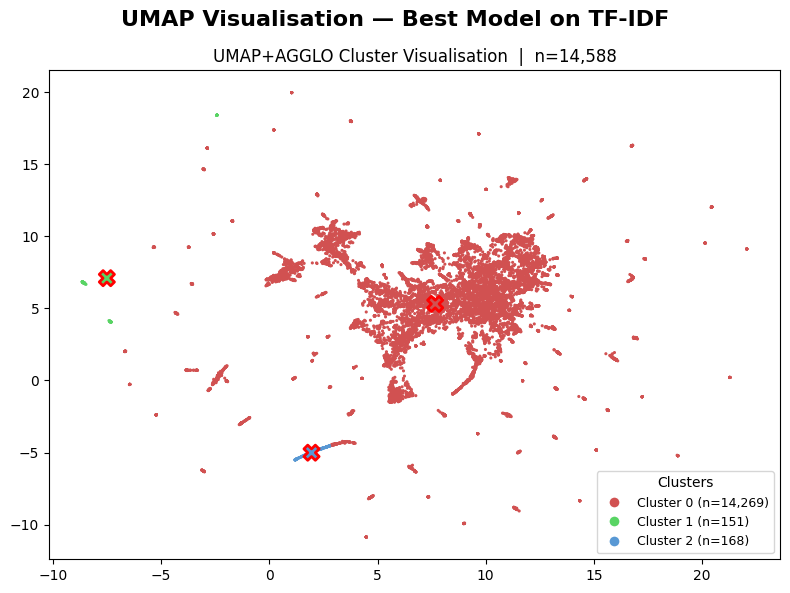

In [8]:
# ===========================
# Visualise the best saved model (Hungarian winner)
# ===========================
import json, joblib, umap
import numpy as np
import matplotlib.pyplot as plt

RANDOM_STATE = 42
palette = ["#d15151", "#58d464", "#5898d4"]  # red / green / blue

META_JSON = "model/tfidf_pipeline_meta.json"
PIPE_PATH = "model/tfidf_pipeline.pkl"

with open(META_JSON, "r") as f:
    meta = json.load(f)
winner = meta["winner"]
print(f"Best model (by Hungarian): {winner['branch']}")
print("Params:", winner["params"])

best = joblib.load(PIPE_PATH)
labels = best.labels_

# 2D projection of the SAME feature space used for clustering
umap_2d = umap.UMAP(n_neighbors=50, min_dist=0.1, n_components=2,
                    metric="euclidean", random_state=RANDOM_STATE)
X_vis = umap_2d.fit_transform(best.X_use_)

fig, ax = plt.subplots(figsize=(8, 6))
colors = np.array(palette)[labels]
ax.scatter(X_vis[:, 0], X_vis[:, 1], c=colors, s=5, edgecolor="none")

unique, counts = np.unique(labels, return_counts=True)
handles = [plt.Line2D([0],[0], marker='o', color='w',
                      label=f"Cluster {k} (n={counts[i]:,})",
                      markerfacecolor=palette[k], markersize=8)
           for i, k in enumerate(unique)]
ax.legend(handles=handles, title="Clusters", loc="best", fontsize=9)

centroids = np.vstack([X_vis[labels == k].mean(axis=0) for k in unique])
ax.scatter(centroids[:, 0], centroids[:, 1], s=120, marker="X",
           c=[palette[k] for k in unique], edgecolor="red", linewidth=2.0, zorder=3)

ax.set_title(f"{winner['branch'].upper()} Cluster Visualisation  |  n={len(labels):,}", fontsize=12)
plt.suptitle("UMAP Visualisation — Best Model on TF-IDF", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()